### Basic Imports

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import seaborn as sns
import pandas as pd

dist =torch.distributions
import torchsummary

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

from functools import partial

In [3]:
n_epochs = 100

In [4]:
from astra.torch.data import load_cifar_10, load_mnist
from astra.torch.utils import train_fn

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/nipun.batra/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [5]:
# Create a sine activation class similar to ReLU
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        return torch.sin(self.w * x + self.b)

In [138]:
# Autoencoder class with 1 hidden layer and hidden dim = z
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=128, z=2, act = nn.ReLU()):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            act, # Using Sine activation
            nn.Linear(hidden_size, z)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z, hidden_size),
            act,
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Sigmoid activation for reconstruction
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [139]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [140]:
dataset = load_mnist()
dataset


MNIST Dataset
length of dataset: 70000
shape of images: torch.Size([28, 28])
len of classes: 10
classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
dtype of images: torch.float32
dtype of labels: torch.int64

In [156]:
# Train over 1000 images
train_idx = torch.arange(1000)

X = dataset.data[train_idx].to(device)
# Add a channel dimension
X = X.unsqueeze(1).float()

X = X/255.0

model = Autoencoder(input_size=784, hidden_size=128, z=32,act=Sine()).to(device)

In [157]:
X.shape

torch.Size([1000, 1, 28, 28])

In [158]:
model(X.view(-1, 28*28*1)).shape

torch.Size([1000, 784])

In [159]:
# Get reconstruction
def get_reconstruction(model, X, model_type='MLP'):
    with torch.no_grad():
        model.eval()
        if model_type == 'MLP':
           X = X.view(-1, 28*28*1)
        X_hat = model(X)
        if model_type == 'MLP':
           X_hat = X_hat.view(-1, 1, 28, 28)
        return X_hat

In [160]:
r = get_reconstruction(model, X)
r.max(), r.min(), r.shape

(tensor(0.5910, device='cuda:0'),
 tensor(0.4162, device='cuda:0'),
 torch.Size([1000, 1, 28, 28]))

In [161]:
nn.MSELoss()(r, X)

tensor(0.2315, device='cuda:0')

In [162]:
# Plot original and reconstructed images
def plot_reconstructions(model, X, n=5, model_type='MLP'):
    X = X[:n]
    X_hat = get_reconstruction(model, X, model_type=model_type)
    # Use torchvision.utils.make_grid to make a grid of images
    X_grid = torch.cat([X, X_hat], dim=0)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


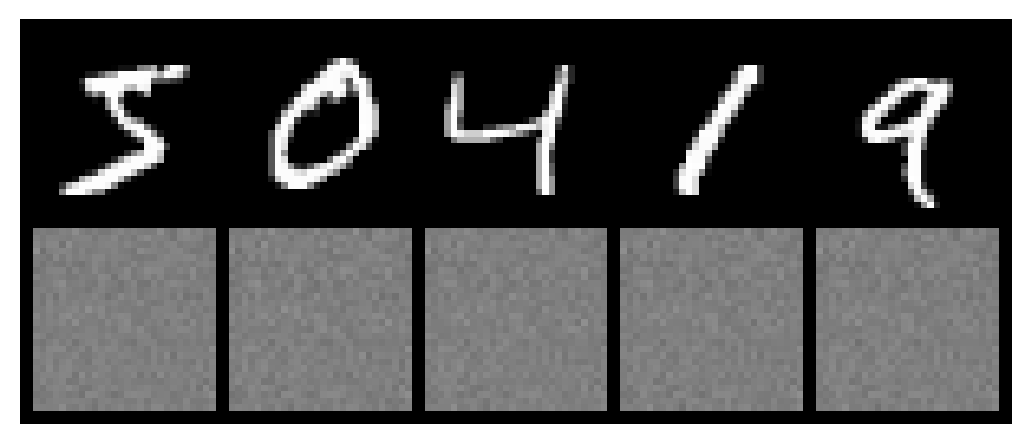

In [163]:
plot_reconstructions(model, X)

In [164]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Sine()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Sine()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [165]:
setattr(model, 'device', device)
iter_losses, epoch_losses = train_fn(model, X.view(-1, 28*28), X.view(-1, 28*28), nn.MSELoss(), lr=0.01, 
                                     batch_size=500, epochs=1000, verbose=False)


In [166]:
r = get_reconstruction(model, X)

In [167]:
r.min(), r.max()

(tensor(2.1998e-12, device='cuda:0'), tensor(1., device='cuda:0'))

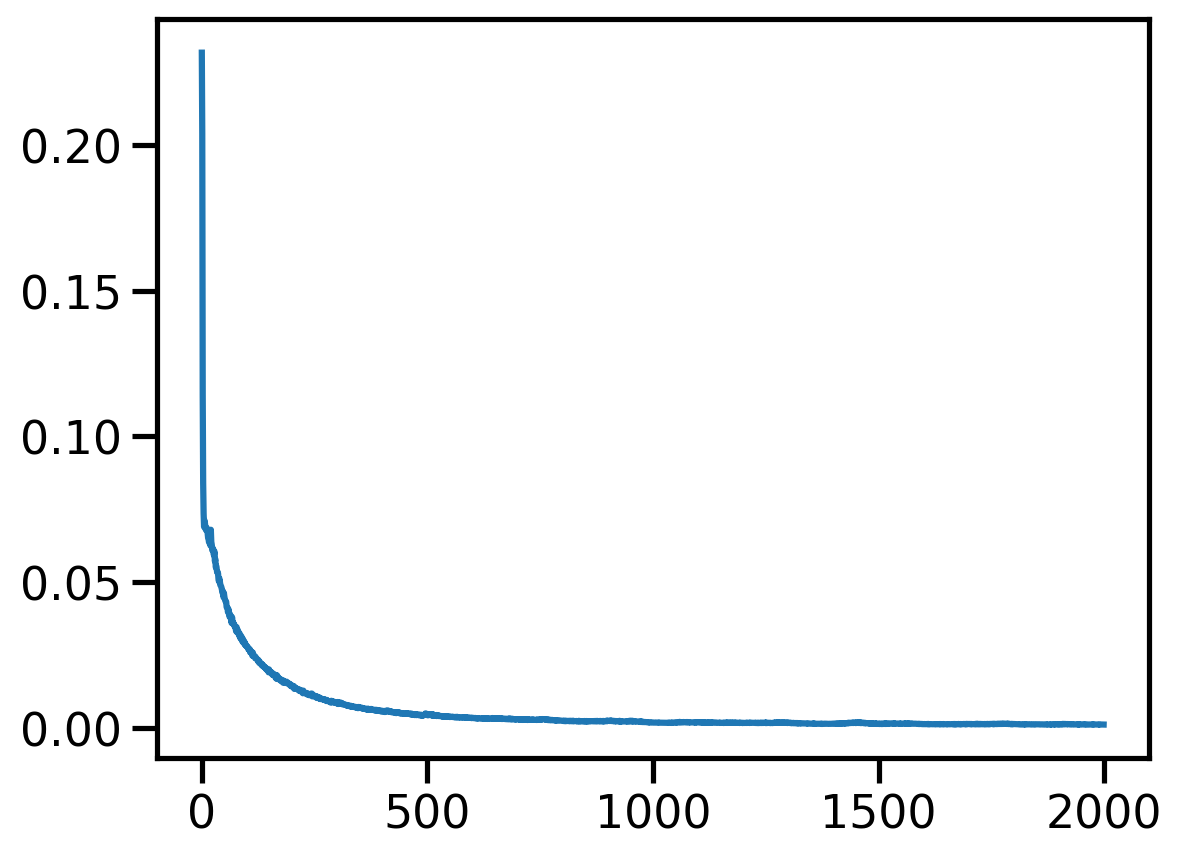

In [168]:
_ = plt.plot(iter_losses)

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


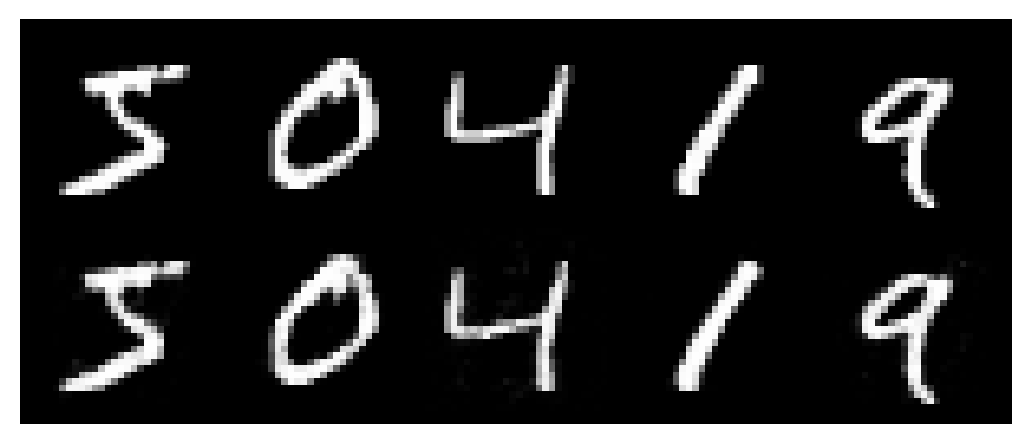

In [169]:
plot_reconstructions(model, X)

In [203]:
# Convolutional AutoEncoder for MNIST
class ConvAutoEncoderMNIST(nn.Module):
    def __init__(self, latent_dim=2, act=nn.ReLU()):
        super(ConvAutoEncoderMNIST, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # 1X28X28 -> 16X28X28
            act,
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1), # 16X28X28 -> 16X28X28
            act,
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # 16X28X28 -> 32X14X14
            act,
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32X14X14 -> 32X14X14
            act,
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), # 32X14X14 -> 64X7X7
            act,
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # 64X7X7 -> 64X7X7
            act,
            nn.Flatten(), # 64X7X7 -> 3136
            nn.Linear(3136, self.latent_dim)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 3136), # 3136 -> 64X7X7
            nn.Unflatten(1, (64, 7, 7)), # 3136 -> 64X7X7
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), # 64X7X7 -> 64X7X7
            act,
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1), # 64X7X7 -> 32X14X14
            act,
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), # 32X14X14 -> 32X14X14
            act,
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # 32X14X14 -> 16X28X28
            act,
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, padding=1), # 16X28X28 -> 16X28X28
            act,
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, padding=1), # 16X28X28 -> 1X28X28
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [204]:
m = ConvAutoEncoderMNIST(latent_dim=32, act=Sine()).to(device)
torchsummary.summary(m, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              Sine-2           [-1, 16, 28, 28]               0
              Sine-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
              Sine-5           [-1, 16, 28, 28]               0
              Sine-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
              Sine-8           [-1, 32, 14, 14]               0
              Sine-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
             Sine-11           [-1, 32, 14, 14]               0
             Sine-12           [-1, 32, 14, 14]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
             Sine-14             [-1, 6

In [205]:
m(X).shape

torch.Size([1000, 1, 28, 28])

In [206]:
latent_dim_ranges = [2, 4, 8, 16, 32, 64, 128]

In [207]:
caes = {}
for latent_dim in latent_dim_ranges[:]:
    caes[latent_dim] = ConvAutoEncoderMNIST(latent_dim=latent_dim, act=Sine()).to(device)
    setattr(caes[latent_dim], 'device', device)

In [208]:
torchsummary.summary(caes[2], (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              Sine-2           [-1, 16, 28, 28]               0
              Sine-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
              Sine-5           [-1, 16, 28, 28]               0
              Sine-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 32, 14, 14]           4,640
              Sine-8           [-1, 32, 14, 14]               0
              Sine-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           9,248
             Sine-11           [-1, 32, 14, 14]               0
             Sine-12           [-1, 32, 14, 14]               0
           Conv2d-13             [-1, 64, 7, 7]          18,496
             Sine-14             [-1, 6

In [187]:
torchsummary.summary(caes[128], (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              Sine-2           [-1, 16, 26, 26]               0
              Sine-3           [-1, 16, 26, 26]               0
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Conv2d-5           [-1, 32, 11, 11]           4,640
              Sine-6           [-1, 32, 11, 11]               0
              Sine-7           [-1, 32, 11, 11]               0
         MaxPool2d-8             [-1, 32, 5, 5]               0
           Flatten-9                  [-1, 800]               0
           Linear-10                  [-1, 128]         102,528
           Linear-11                  [-1, 800]         103,200
        Unflatten-12             [-1, 32, 5, 5]               0
  ConvTranspose2d-13             [-1, 16, 7, 7]           4,624
             Sine-14             [-1, 1

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


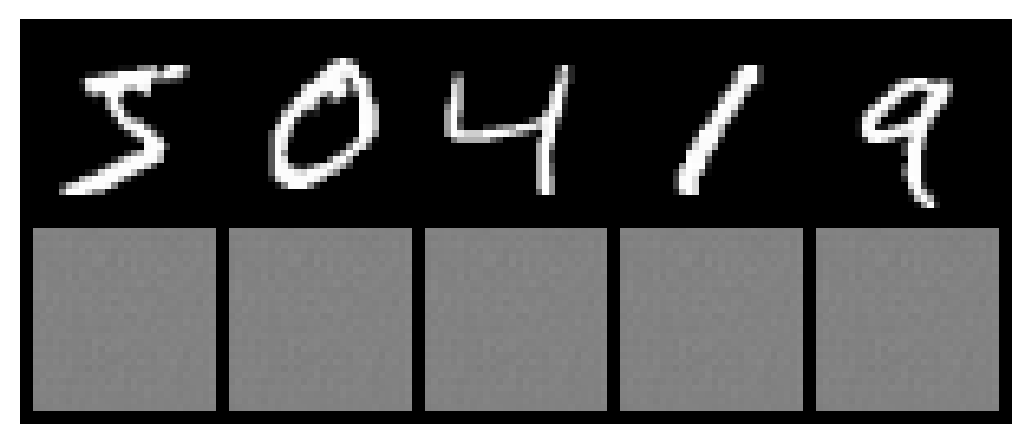

In [209]:
plot_reconstructions(caes[2], X, 5, model_type='CNN')

In [232]:
i_loss = {}
e_loss = {}
for latent_dim in latent_dim_ranges[:]:
    print(f"Training for latent_dim = {latent_dim}")
    i_loss[latent_dim], e_loss[latent_dim] = train_fn(caes[latent_dim], X, X, nn.MSELoss(), lr=3e-4, 
                                                      batch_size=128, epochs=1000, verbose=False)


Training for latent_dim = 2
Training for latent_dim = 4
Training for latent_dim = 8
Training for latent_dim = 16


KeyboardInterrupt: 

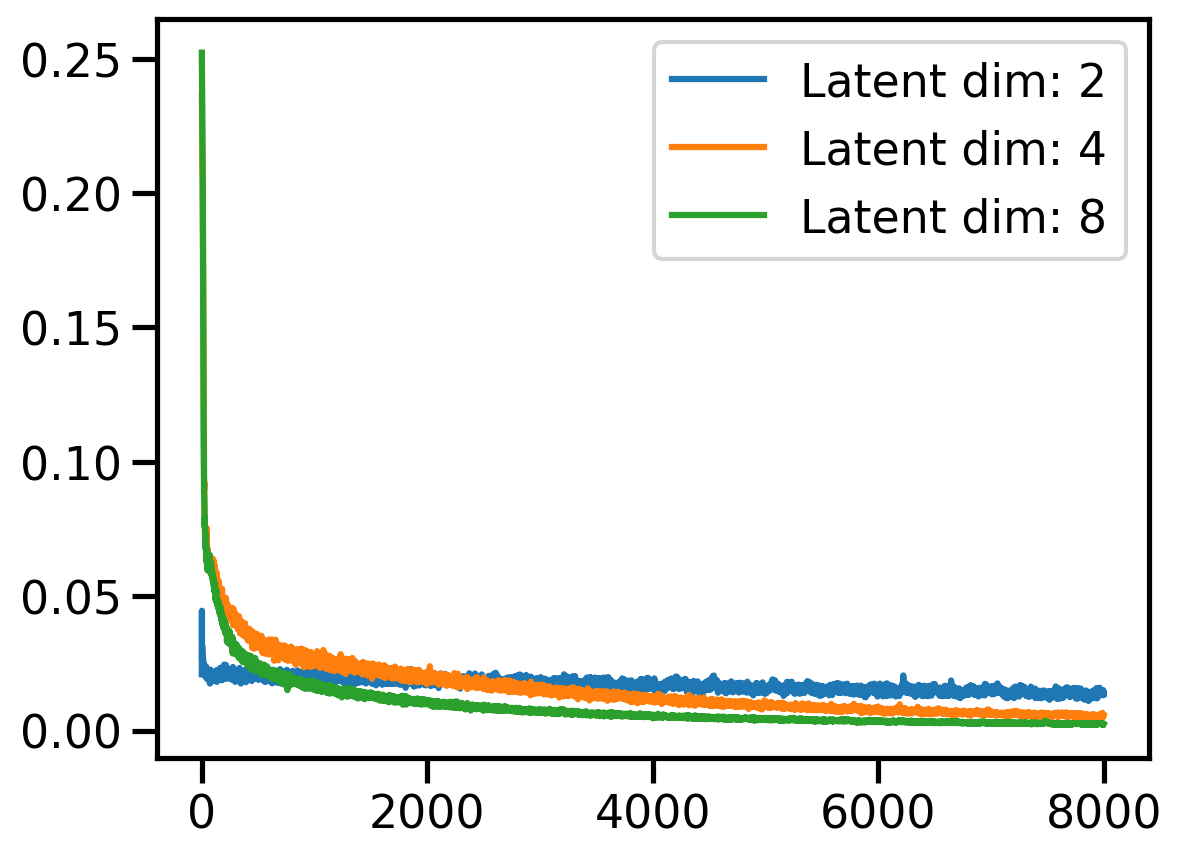

In [233]:
for latent_dim in latent_dim_ranges[:3]:
    plt.plot(i_loss[latent_dim], label=f'Latent dim: {latent_dim}')
plt.legend()

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


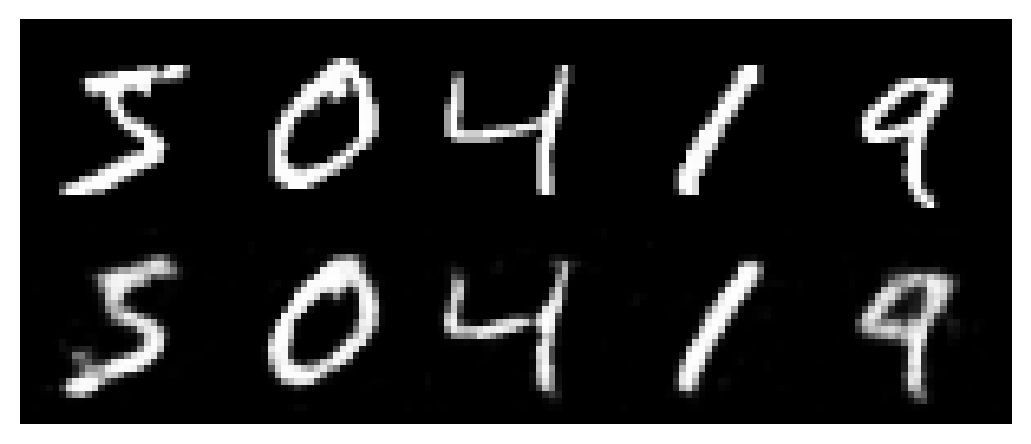

In [234]:
# Plot reconstructions
plot_reconstructions(caes[2], X, 5, model_type='CNN')

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


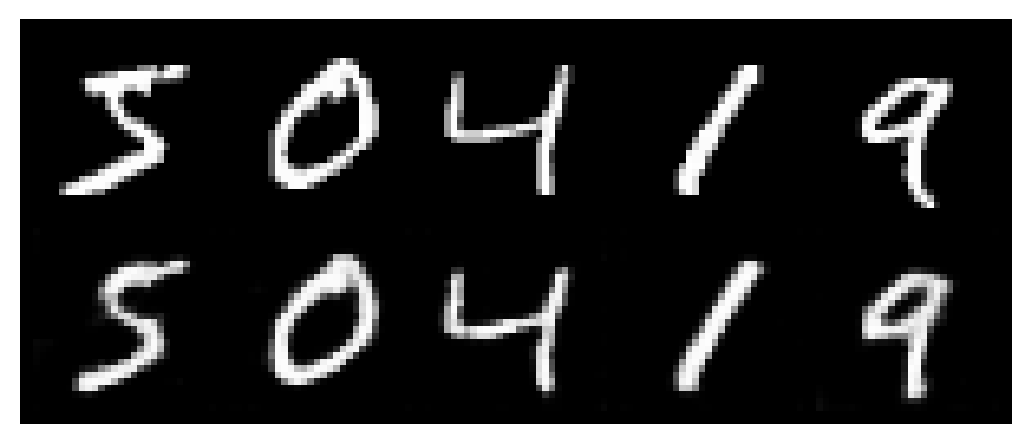

In [235]:
plot_reconstructions(caes[4], X, 5, 'CNN')

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


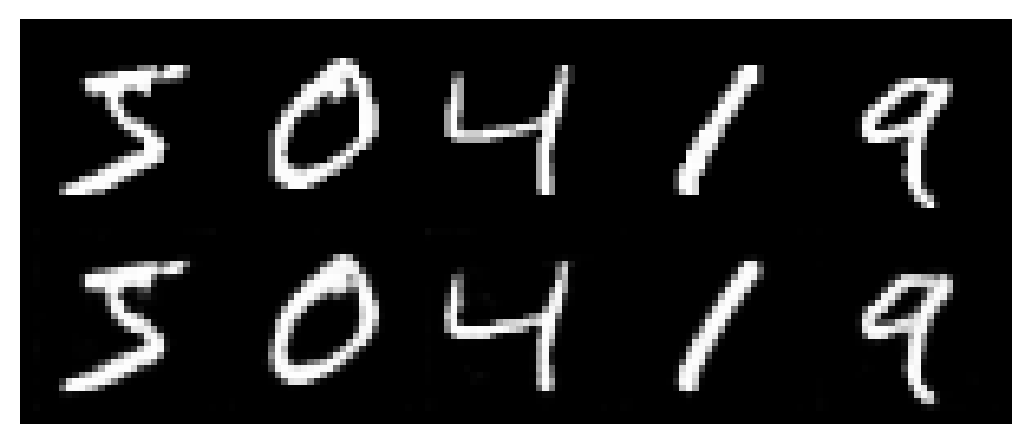

In [236]:
plot_reconstructions(caes[8], X, 5, 'CNN')

/tmp/ipykernel_677386/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


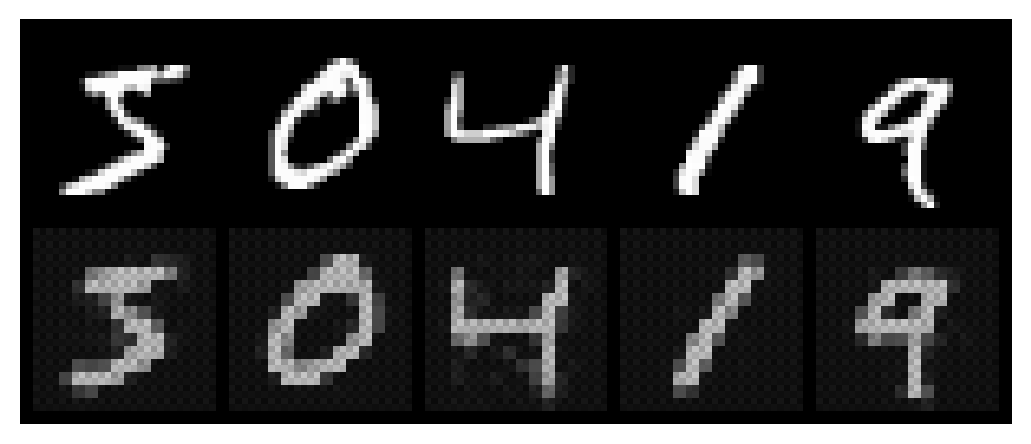

In [194]:
plot_reconstructions(caes[16], X, 5, 'CNN')

/tmp/ipykernel_677038/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


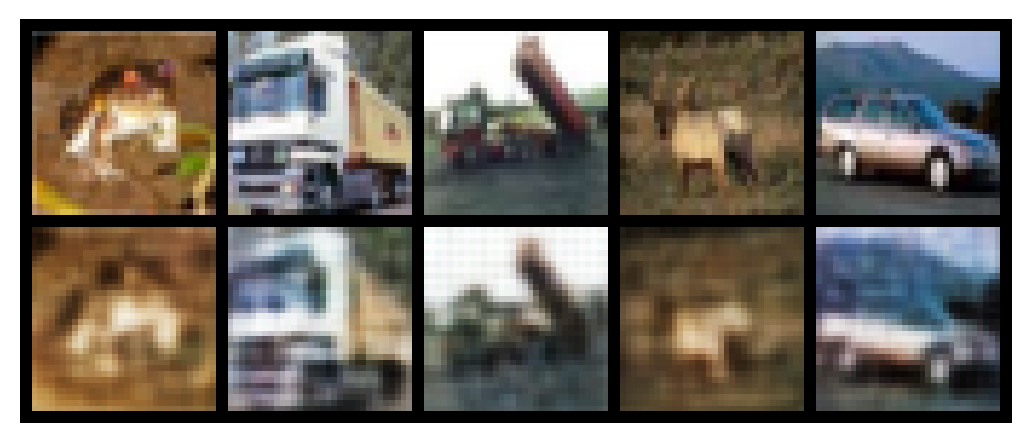

In [29]:
plot_reconstructions(caes[128], X, 5, 'CNN')

In [237]:
# Give a random input to the model and get the output
def get_random_output(model, n=5, latent_dim=2):
    with torch.no_grad():
        model.eval()
        z = torch.randn(n, latent_dim).to(device)
        X_hat = model.decoder(z)
        return X_hat

# Plot random outputs
def plot_random_outputs(model, n=5, latent_dim=2):
    X_hat = get_random_output(model, n, latent_dim)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_677386/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


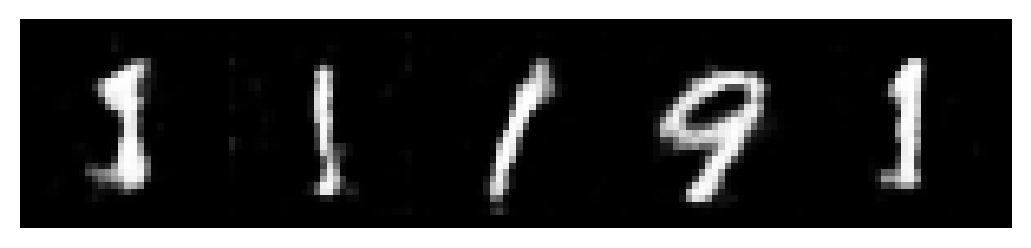

In [239]:
plot_random_outputs(caes[2])

/tmp/ipykernel_677386/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


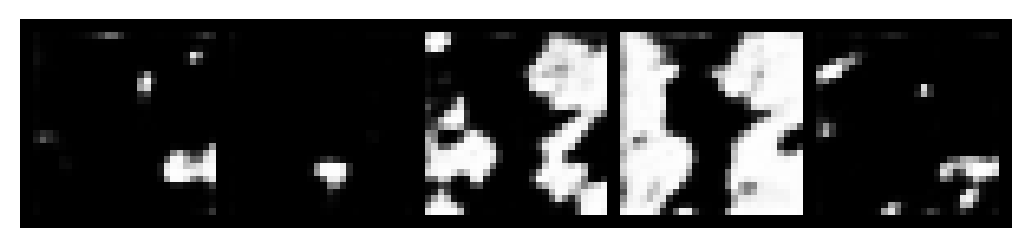

In [244]:
plot_random_outputs(caes[8], latent_dim=8)

In [245]:
# Interpolate between two points in latent space
def interpolate(model, z1, z2, n=5):
    with torch.no_grad():
        model.eval()
        z = torch.zeros(n, z1.shape[1]).to(device)
        for i in range(n):
            z[i] = z1 + (z2 - z1) * (i / (n - 1))
        X_hat = model.decoder(z)
        return X_hat

# Plot interpolation
def plot_interpolation(model, img1, img2, n=5):
    z1 = model.encoder(X[img1].unsqueeze(0))
    z2 = model.encoder(X[img2].unsqueeze(0))
    X_hat = interpolate(model, z1, z2, n)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_677386/2692072581.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


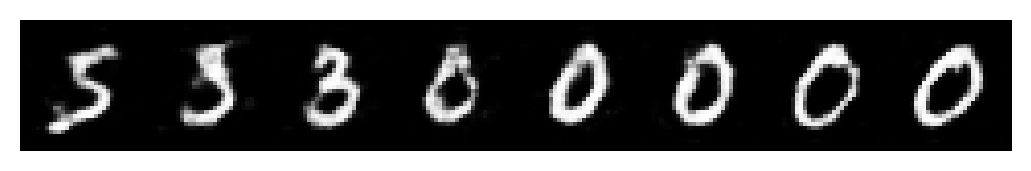

In [249]:
plot_interpolation(caes[2], 0, 1, 8)

/tmp/ipykernel_677386/2692072581.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


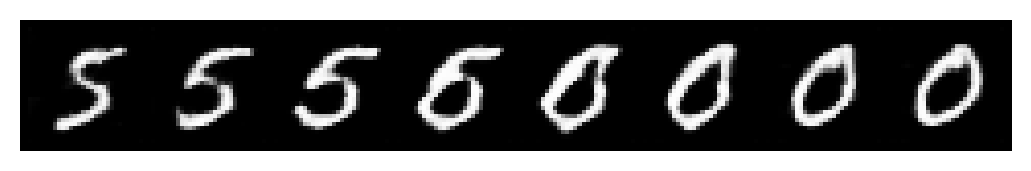

In [250]:
plot_interpolation(caes[4], 0, 1, 8)

/tmp/ipykernel_677386/2692072581.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


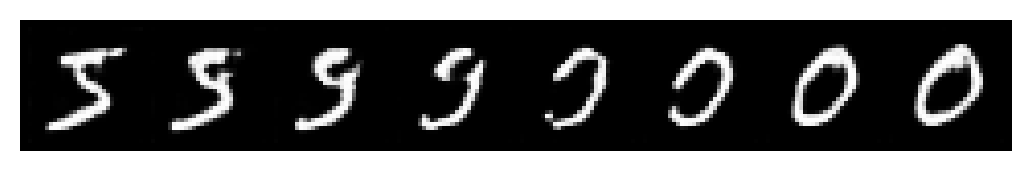

In [251]:
plot_interpolation(caes[8], 0, 1, 8)